In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import json
import math
import datetime
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap

%matplotlib inline
from yahoofinancials import YahooFinancials

from bs4 import BeautifulSoup

In [5]:
tickers = ["SPY", "QQQ", "TQQQ", "MSFT", "^VIX", "AAPL", "NVDA", "AMD","MRNA", "UPRO"]

start_date = "2019-08-30" #"2013-11-20" # "2018-6-15" #"2016-10-15"

end_date = str(datetime.date.today()) # "2019-3-30"# 

update = True

if update:
	stocks = YahooFinancials(tickers)
	historical_price = stocks.get_historical_price_data(start_date, end_date, "weekly")

	with open('data/data_ls.py', 'w') as outfile:
	
		outfile.write("historical_price=")

		json.dump(historical_price, outfile)

else:
	from data.data_ls import historical_price

	historical_price = historical_price
    
chart_data = {}
other_tickers = {}
longest = 0
longest_ticker = "ICE"


for ticker in tickers:
	# for all data before sorting
	# print ticker
	chart_data[ticker] = historical_price[ticker]["prices"]

	other_tickers[ticker] = len(historical_price[ticker]["prices"])

	if len(historical_price[ticker]["prices"]) > longest:

		longest = len(historical_price[ticker]["prices"])

		longest_ticker = ticker

save_data = {}
save_data["date"] = []
save_data["formatted_date"] = []

def load_ticker_data(ticker, chart_data):
    rf_list = list()
    for i in range(0, len(chart_data[ticker]) ):
        rf_list.append( [ pd.to_datetime(chart_data[ticker][i]["formatted_date"]), \
                    chart_data[ticker][i]["adjclose"], chart_data[ticker][i]["high"],\
                    chart_data[ticker][i]["low"], chart_data[ticker][i]["open"],
                    chart_data[ticker][i]["close"], chart_data[ticker][i]["volume"]  
                    ])
    df = pd.DataFrame(rf_list, columns=["date", "adjclose", "high","low", "open", "close", "volume"]) # , 
    df = df.set_index("date")
    return df

prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = load_ticker_data(ticker, chart_data).open

## GOAL is to minimize drawdown

In [8]:
prices=prices.fillna(0)

In [9]:
from statsmodels.tsa.stattools import coint

for ticker in tickers:
    t = "TQQQ"
    print("----"*30)
    print(ticker)
    print(prices[t].corr(prices[ticker]))
    t_stat, p_value, _ = coint(prices[t], prices[ticker])
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

------------------------------------------------------------------------------------------------------------------------
SPY
0.7957401777407674
T-statistic: -1.3917
P-value: 0.8004
------------------------------------------------------------------------------------------------------------------------
QQQ
0.8440301320540025
T-statistic: -1.2154
P-value: 0.8538
------------------------------------------------------------------------------------------------------------------------
TQQQ
0.9999999999999998
T-statistic: -inf
P-value: 0.0000
------------------------------------------------------------------------------------------------------------------------
MSFT
0.7146392663163929
T-statistic: -1.6228
P-value: 0.7112
------------------------------------------------------------------------------------------------------------------------
^VIX
-0.3888955861443596
T-statistic: -2.1548
P-value: 0.4478
----------------------------------------------------------------------------------------------

C:\Users\charles\AppData\Local\Temp\ipykernel_8152\363538895.py:8: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  t_stat, p_value, _ = coint(prices[t], prices[ticker])


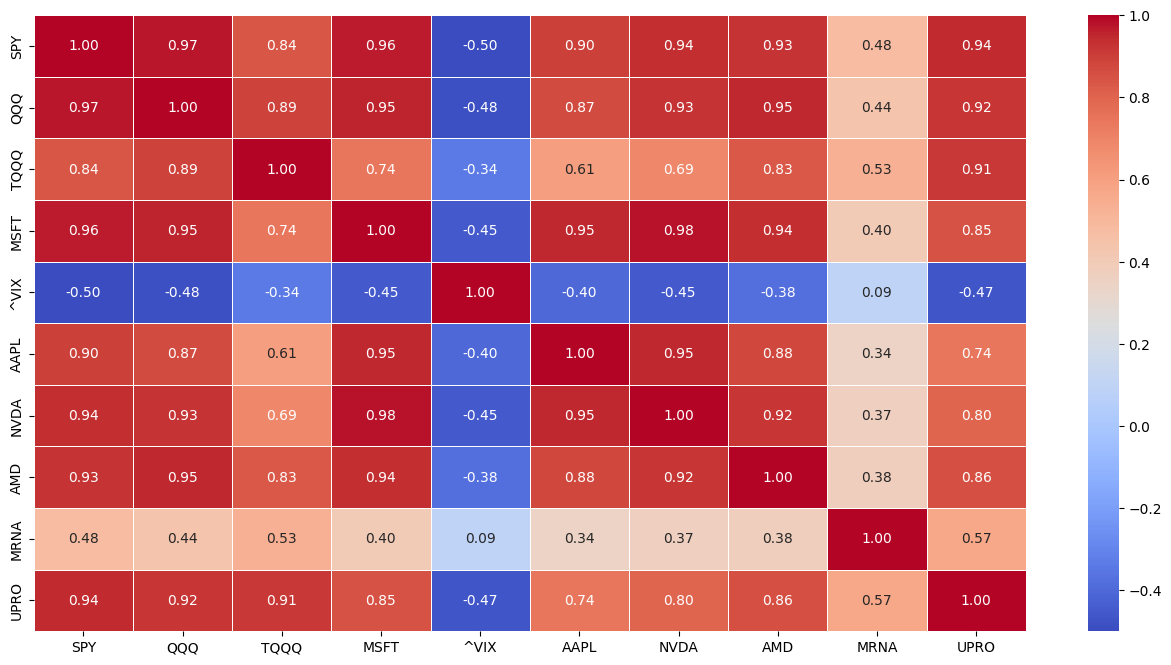

In [10]:
# Let's also draw a heatmap visualization of the correlation matrix
corr_matrix = prices.corr(method='spearman')
#corr_matrix[corr_matrix > 0.75].to_csv("data/corr.csv")
#print(corr_matrix[corr_matrix > 0.9])
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

C:\Users\charles\AppData\Local\Temp\ipykernel_8152\953178967.py:13: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



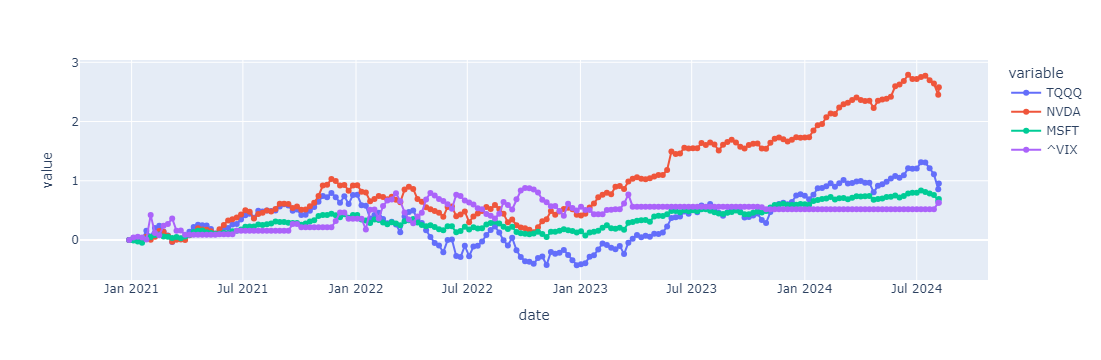

In [11]:
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import plotly.offline as offline_py

offline_py.init_notebook_mode(connected=True)
df_ls = pd.DataFrame()
df_ls["TQQQ"] = prices["TQQQ"]
df_ls["NVDA"] = prices["NVDA"]
df_ls["MSFT"] = prices["MSFT"]
df_ls["^VIX"] = prices["^VIX"][prices["^VIX"]>20]

df_fig = df_ls[df_ls.index >= "2020-12-26"].pct_change().fillna(0).cumsum()
fig = px.scatter(df_fig)

fig.update_traces(mode='markers+lines')

fig.show()

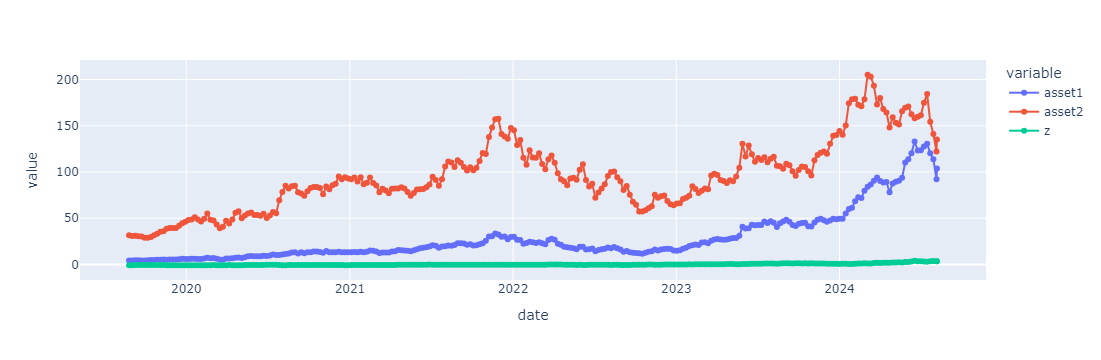

In [12]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = prices["NVDA"]
signals['asset2'] = prices["AMD"]
ratios = signals.asset1 / signals.asset2
# calculate z-score and define upper and lower thresholds
signals["z"] = zscore(ratios)
signals

fig = px.scatter(signals)

fig.update_traces(mode='markers+lines')

fig.show()

259
date
2019-09-02    1.018396
2019-09-09    1.109891
2019-09-16    1.123940
2019-09-23    1.094119
2019-09-30    1.139433
                ...   
2024-07-15    3.823747
2024-07-22    4.151200
2024-07-29    4.272459
2024-08-05    4.035460
2024-08-06    4.123980
Length: 259, dtype: float64
1.8024315921981224


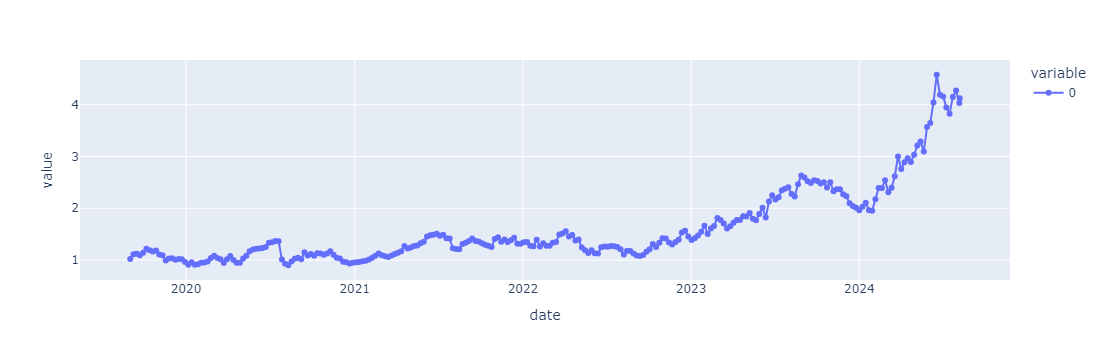

In [15]:
returns = prices.pct_change().dropna()
#for ticker in tickers:
df = returns["NVDA"].subtract(returns["AMD"])
print(df.count())
print((df+1).cumprod())
print(df.sum())

df_fig = (df+1).cumprod()
fig = px.scatter(df_fig)

fig.update_traces(mode='markers+lines')

fig.show()

#df.to_excel("data/ls1.xlsx")